# Industry energy demand

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'EDeMOS':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\EDeMOS


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd

# Spatial
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
from pyproj import CRS
from rasterstats import zonal_stats

# Plot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
import config
from utils import processing_raster, finalizing_rasters, spatialjoinvectors
from Industry import energy_per_site
from Industry.data_loader import load_initial_data, load_and_process_energy_balance

INFO: Successfully loaded configuration for Zambia from config.py.


In [4]:
from plotting import plot_sector_consumption_map

In [5]:
pd.options.display.float_format = '{:,.4f}'.format

### Import admin layers

In [6]:
regions_list, admin_gdf, region_gdf, grid, hexagons = load_initial_data(config)

Loading initial data...
Admin boundaries loaded. Country GDF: (1, 3), Region GDF: (10, 12)
Hexagon grid loaded: (122901, 11)


# Part 1. Extract GIS-based attributes

## Extract information from vector layers

Assess the energy consumption per site

In [7]:
## Running the energy calculation function 
from Industry import energy_per_site

energy_per_site.calc_energy_per_site(config)

Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mkushi Heap Leach  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mufulira West Heap-Leach Facility  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  TD3a, TD3b, TD5, and TD7 Tailings Dams  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
File C:\Users\amillot\PycharmProjects\EDeMOS\Industry\Data\mines\mineral_facilities_zambia.gpkg exists. Deleting it now...
File deleted.


Extract sum production of mines in each cluster (hex)

In [8]:
grid, mines = spatialjoinvectors(config.COL_IND_ELEC_TJ, admin_gdf, config.CRS_WGS84, grid, "sum", config.MINES_OUTPUT_GPKG)
grid, mines_data = spatialjoinvectors(config.COL_IND_COPPER_ELEC_TJ, admin_gdf, config.CRS_WGS84, grid, "sum", config.MINES_OUTPUT_GPKG)

CRS matched successfully for points_correct.
CRS matched successfully for points_correct.


In [9]:
grid[config.COL_IND_ELEC_TJ].sum()

np.float64(18730.483503139287)

In [10]:
grid[config.COL_IND_COPPER_ELEC_TJ].sum()

np.float64(16267.012581639287)

In [11]:
grid.head(2)

,h3_index,n0,n1,n2,n3,n4,n5,index,NAME_1,id,geometry,ind_elec_TJ,copper_elec_TJ
0,879753661ffffff,44592,48497,"42,103.0000","41,851.0000","32,577.0000","44,217.0000",0,Southern,1,"POLYGON ((26.09731 -16.79199, 26.08433 -16.798...",NaN,NaN
1,879758832ffffff,35993,114444,"106,897.0000","121,703.0000","114,034.0000","52,740.0000",1,Western,2,"POLYGON ((24.0273 -17.45984, 24.0143 -17.46579...",NaN,NaN


In [12]:
mines.head(2)

,Country,FeatureNam,DsgAttr02,DsgAttr03,DsgAttr06,MemoOther,MemoLoc,Latitude,Longitude,DsgAttr07,...,Mine type,Metal processing,Metal process type,Spec energy Elec [GJ/t],Spec energy Diesel [GJ/t],ind_elec_TJ,ind_diesel_TJ,copper_elec_TJ,id,geometry
0,Zambia,Baluba Center Underground Mine,Copper,Concentrate,2017,Ore. Operations suspended. Facility on care-an...,<null>,-13.0486,28.3381,"1,500,000.0000",...,Underground,,,11.7500,2.1500,140.3285,25.6771,140.3285,1,POINT (28.33806 -13.04861)
1,Zambia,Bwana Mkubwa Solvent Extraction-Electrowinning...,Copper,Metal,2017,Copper cathode.,<null>,-13.0423,28.7094,"52,000.0000",...,,Hydrometallurgical,"Solvent Extraction-Electrowinning, Electrowinn...",12.4950,2.2050,202.7189,35.7739,202.7189,2,POINT (28.70935 -13.0423)


# Part 2. Compute demand

In [13]:
un_energy_data = load_and_process_energy_balance(config)

Loading and processing energy balance data...
Energy balance data processed. UN stats:
elec_nonFerrousMetals_TJ: 22,897.0 TJ
elec_mining_TJ: 818.0 TJ
oil_nonFerrousMetals_TJ: 1,191.1 TJ
oil_mining_TJ: 2,689.7 TJ
elec_ind_TJ: 23,715.0 TJ
oil_ind_TJ: 3,880.8 TJ
energy_ind_TJ: 27,595.8 TJ


In [14]:
elec_mining_consum = mines[mines["Output type (ass.)"].isin(["Ore and concentrate", "Metal in ore"])][config.COL_IND_ELEC_TJ].sum()

In [15]:
# Assess total energy consumption and total production
total_elec_consum = mines[config.COL_IND_ELEC_TJ].sum() # total
total_oil_consum = mines[config.COL_IND_OIL_TJ].sum() # total
total_energy_consum = total_elec_consum + total_oil_consum

coverage_energy_nonFe_mining = total_energy_consum / un_energy_data['energy_ind_TJ'] if un_energy_data['energy_ind_TJ'] else 0
coverage_elec_nonFe_mining = total_elec_consum / un_energy_data['elec_ind_TJ'] if un_energy_data['elec_ind_TJ'] else 0
coverage_oil_nonFe_mining = total_oil_consum / un_energy_data['oil_ind_TJ'] if un_energy_data['oil_ind_TJ'] else 0

mines_mining = mines[mines["Output type (ass.)"].isin(["Ore and concentrate", "Metal in ore"])]
elec_mining_consum = mines_mining[config.COL_IND_ELEC_TJ].sum()
oil_mining_consum = mines_mining[config.COL_IND_OIL_TJ].sum()
mines_nonFerrous = mines[mines["Output type (ass.)"].isin(["Metal"])]
elec_nonFerrousMetals_consum = mines_nonFerrous[config.COL_IND_ELEC_TJ].sum()
oil_nonFerrousMetals_consum = mines_nonFerrous[config.COL_IND_OIL_TJ].sum()

# print("total production:", f"{total_production/10**3:,.0f}", "kt")
print("total calculated electricity", f"{total_elec_consum:,.1f}",
      "TJ (mining: ", f"{elec_mining_consum:,.1f}",", non-Fe:",f"{elec_nonFerrousMetals_consum:,.1f}", ")")
print("total calculated diesel", f"{total_oil_consum:,.1f}",
      "TJ (mining: ",f"{oil_mining_consum:,.1f}",", non-Fe:",f"{oil_nonFerrousMetals_consum:,.1f}", ")")
print("total calculated energy consumption:", f"{total_energy_consum:,.1f}", "TJ")
print("----------------------------------------------------------------------------------------")
print("Coverage energy in statistical nonFerrousMetals and mining consumption:", f"{coverage_energy_nonFe_mining*100:,.0f}", "%")
print("----------------------------------------------------------------------------------------")
print("Coverage electricity in statistical nonFerrousMetals and mining consumption:", f"{coverage_elec_nonFe_mining*100:,.0f}", "%")
print("Coverage fuel/oil in statistical nonFerrousMetals and mining consumption:", f"{coverage_oil_nonFe_mining*100:,.0f}", "%")
print("----------------------------------------------------------------------------------------")
print("Coverage electricity in statistical mining consumption:", f"{elec_mining_consum/un_energy_data['elec_ind_TJ']*100:,.0f}", "%")
print("Coverage fuel/oil in statistical mining consumption:", f"{oil_mining_consum/un_energy_data['oil_ind_TJ']*100:,.0f}", "%")
print("Coverage electricity in statistical nonFerrousMetals consumption:", f"{elec_nonFerrousMetals_consum/un_energy_data['elec_nonFerrousMetals_TJ']*100:,.0f}", "%")
print("Coverage fuel/oil in statistical nonFerrousMetals consumption:", f"{oil_nonFerrousMetals_consum/un_energy_data['oil_nonFerrousMetals_TJ']*100:,.0f}", "%")

total calculated electricity 18,730.5 TJ (mining:  9,341.5 , non-Fe: 9,389.0 )
total calculated diesel 7,022.9 TJ (mining:  4,131.6 , non-Fe: 2,891.4 )
total calculated energy consumption: 25,753.4 TJ
----------------------------------------------------------------------------------------
Coverage energy in statistical nonFerrousMetals and mining consumption: 93 %
----------------------------------------------------------------------------------------
Coverage electricity in statistical nonFerrousMetals and mining consumption: 79 %
Coverage fuel/oil in statistical nonFerrousMetals and mining consumption: 181 %
----------------------------------------------------------------------------------------
Coverage electricity in statistical mining consumption: 39 %
Coverage fuel/oil in statistical mining consumption: 106 %
Coverage electricity in statistical nonFerrousMetals consumption: 41 %
Coverage fuel/oil in statistical nonFerrousMetals consumption: 243 %


In [16]:
# Allocate to each hexagon the industry energy consumption
# adjust energy consumption if coverage is the whole country
if config.AREA_OF_INTEREST == "COUNTRY":
    grid[config.COL_IND_ELEC_SCALED_TJ]=grid[config.COL_IND_ELEC_TJ]/coverage_elec_nonFe_mining  # TJ
else:
    grid[config.COL_IND_ELEC_SCALED_TJ]=grid[config.COL_IND_ELEC_TJ] # TJ
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,index,NAME_1,id,geometry,ind_elec_TJ,copper_elec_TJ,ind_elec_scaled_kWh
0,879753661ffffff,44592,48497,"42,103.0000","41,851.0000","32,577.0000","44,217.0000",0,Southern,1,"POLYGON ((26.09731 -16.79199, 26.08433 -16.798...",NaN,NaN,NaN
1,879758832ffffff,35993,114444,"106,897.0000","121,703.0000","114,034.0000","52,740.0000",1,Western,2,"POLYGON ((24.0273 -17.45984, 24.0143 -17.46579...",NaN,NaN,NaN
2,879673ae2ffffff,43152,82272,"45,138.0000","118,829.0000","11,841.0000","101,308.0000",2,North-Western,3,"POLYGON ((22.5831 -13.02245, 22.57036 -13.0284...",NaN,NaN,NaN


In [18]:
total_industry_electricity_beforescaling_tj = grid[config.COL_IND_ELEC_TJ].sum()
total_industry_electricity_afterscaling_tj = grid[config.COL_IND_ELEC_SCALED_TJ].sum()
print("Industry electricity consumption before scaling in",f"{config.AREA_OF_INTEREST}", ":",f"{total_industry_electricity_beforescaling_tj/3600:,.1f}", "TWh")
print("Industry electricity consumption after scaling in",f"{config.AREA_OF_INTEREST}", ":",f"{total_industry_electricity_afterscaling_tj/3600:,.1f}", "TWh")
print("Industry UN stats electricity consumption in",f"{config.AREA_OF_INTEREST}", ":",f"{un_energy_data['elec_ind_TJ']/3600:,.1f}", "TWh")

Industry electricity consumption before scaling in COUNTRY : 5.2 TWh
Industry electricity consumption after scaling in COUNTRY : 6.6 TWh
Industry UN stats electricity consumption in COUNTRY : 6.6 TWh


In [19]:
# grid.to_file(config.INDUSTRY_SHP_FILE, index=False)
# grid.to_file(config.INDUSTRY_GEOJSON_FILE, driver='GeoJSON', index=False)  
grid.to_file(config.INDUSTRY_GPKG_FILE, layer="mines", driver="GPKG", mode='w')
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,index,NAME_1,id,geometry,ind_elec_TJ,copper_elec_TJ,ind_elec_scaled_kWh
0,879753661ffffff,44592,48497,"42,103.0000","41,851.0000","32,577.0000","44,217.0000",0,Southern,1,"POLYGON ((26.09731 -16.79199, 26.08433 -16.798...",NaN,NaN,NaN
1,879758832ffffff,35993,114444,"106,897.0000","121,703.0000","114,034.0000","52,740.0000",1,Western,2,"POLYGON ((24.0273 -17.45984, 24.0143 -17.46579...",NaN,NaN,NaN
2,879673ae2ffffff,43152,82272,"45,138.0000","118,829.0000","11,841.0000","101,308.0000",2,North-Western,3,"POLYGON ((22.5831 -13.02245, 22.57036 -13.0284...",NaN,NaN,NaN


# Part 3: Industry mapping

In [20]:
# Retrieve copper values and convert in GWh
grid['Copper_elec_GWh'] = grid[config.COL_IND_COPPER_ELEC_TJ] / 3.6
totalperregion=grid.groupby(config.ADMIN_REGION_COLUMN_NAME)['Copper_elec_GWh'].sum()
grid['total_copper_elec_perregion_GWh'] = grid[config.ADMIN_REGION_COLUMN_NAME].map(totalperregion)
totalperregion

NAME_1
Central            15.1606
Copperbelt      2,506.5455
Eastern             0.0000
Luapula             0.0000
Lusaka              0.0000
Muchinga            0.0000
North-Western   1,992.6194
Northern            0.0000
Southern            4.2891
Western             0.0000
Name: Copper_elec_GWh, dtype: float64

In [21]:
grid_filtered = grid[grid[config.ADMIN_REGION_COLUMN_NAME] == 'Copperbelt']
region_gdf_filtered = region_gdf[region_gdf[config.ADMIN_REGION_COLUMN_NAME] == 'Copperbelt']
hexagons_filtered = hexagons[hexagons[config.ADMIN_REGION_COLUMN_NAME] == 'Copperbelt']

Plotting Copper Consumption map...


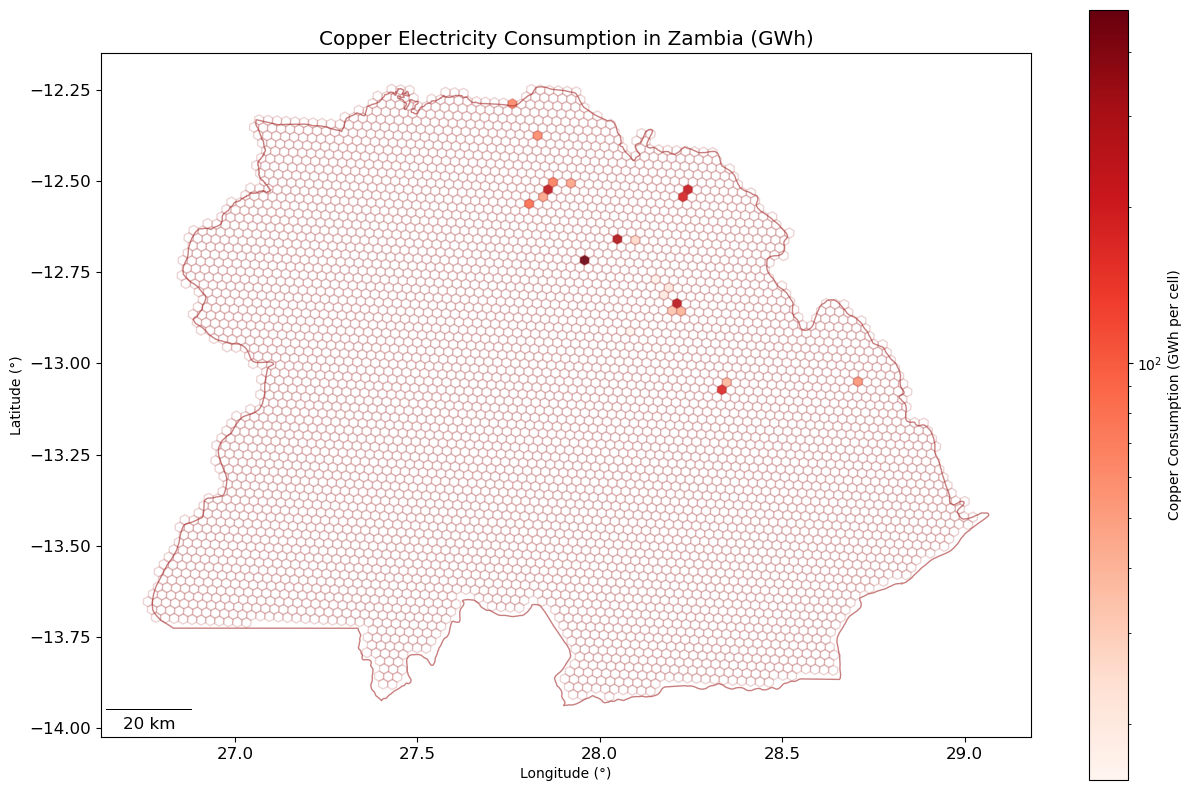

In [22]:
plot_sector_consumption_map(grid_filtered, 'Copper_elec_GWh', config, region_gdf_filtered, hexagons_filtered, 'Copper',
                           lines_gdf=None, fig_size=(15, 10))

Plotting Copper Region Consumption map...


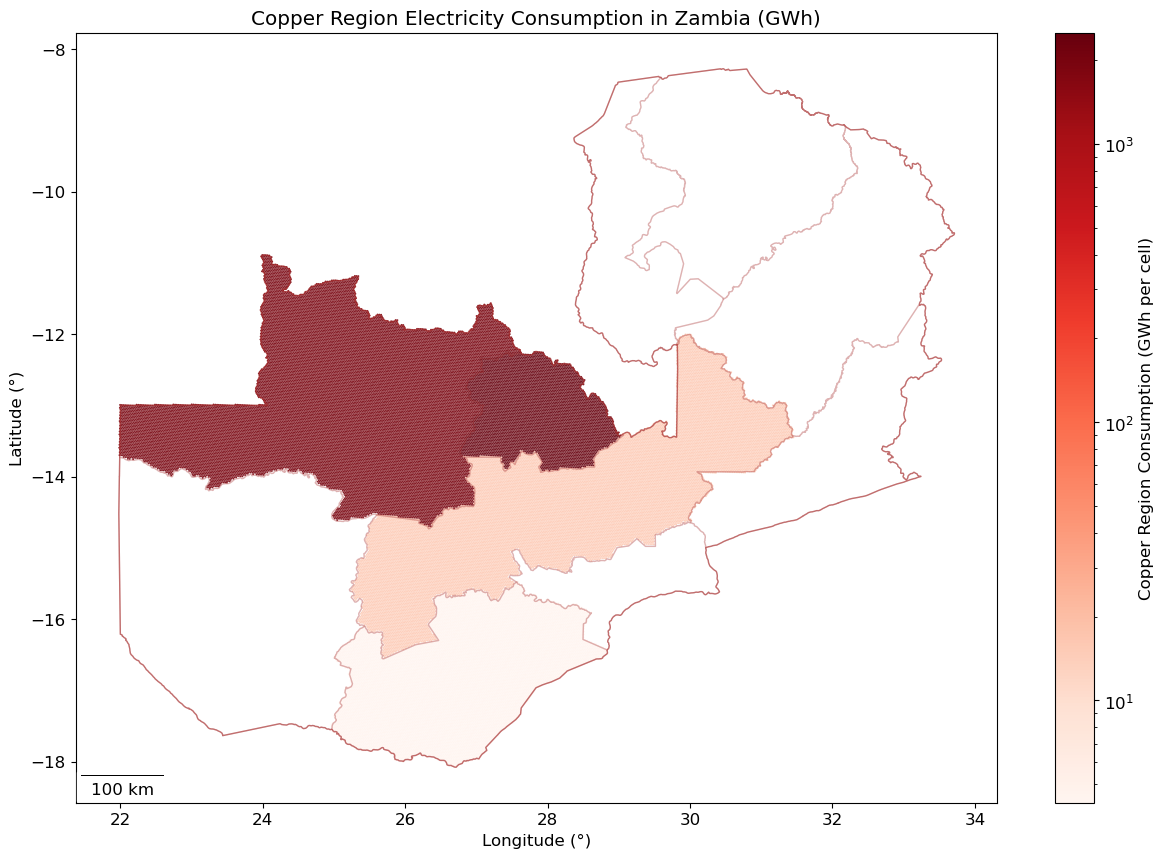

In [23]:
plot_sector_consumption_map(grid, 'total_copper_elec_perregion_GWh', config, admin_gdf, region_gdf, 'Copper Region',
                           lines_gdf=None, fig_size=(15, 10))